In [1]:
# https://www.kaggle.com/c/humpback-whale-identification

Author: KaiPin Liao 

Date: 2019/01/01
### remove text and white band 
### resize to (1050, 605) 
### color to black_and_white


In [13]:
import glob, os
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import math
from numpy import newaxis
from tqdm import tqdm
%matplotlib inline

**Label file analysis**

In [3]:
CSV_PATH   = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/'
READ_PATH  = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train/'
WRITE_PATH = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_remove_text/'

In [4]:
# read label csv
df = pd.read_csv(CSV_PATH+'train.csv')
print(df.head())
print('There are ', len(df), 'pictures.')

# get unique whales
whales = df['Id'].drop_duplicates().values
print('There are ', len(whales), 'unique whales.')

# there are on average ~5 unique pictures per whale. What does this look like distributionally?
count = df.groupby('Id').count().sort_values('Image', ascending=False).reset_index()

# there are ~9.5K examples in the new whales class, dominating all others
print(count.head())

# ~2K whales only have one sample image... this will make validation conceptually difficult
print(len(count[count['Image']==1]), 'whales have only one sample image.', len(count[count['Image']==1]) / len(whales))

# yikes ~4K whales have less than five images... this will be tough!
print(len(count[count['Image']<=5]), 'whales have less than 5 images.', len(count[count['Image']<=5]) / len(whales))

           Image         Id
0  0000e88ab.jpg  w_f48451c
1  0001f9222.jpg  w_c3d896a
2  00029d126.jpg  w_20df2c5
3  00050a15a.jpg  new_whale
4  0005c1ef8.jpg  new_whale
There are  25361 pictures.
There are  5005 unique whales.
          Id  Image
0  new_whale   9664
1  w_23a388d     73
2  w_9b5109b     65
3  w_9c506f6     62
4  w_0369a5c     61
2073 whales have only one sample image. 0.4141858141858142
4371 whales have less than 5 images. 0.8733266733266734


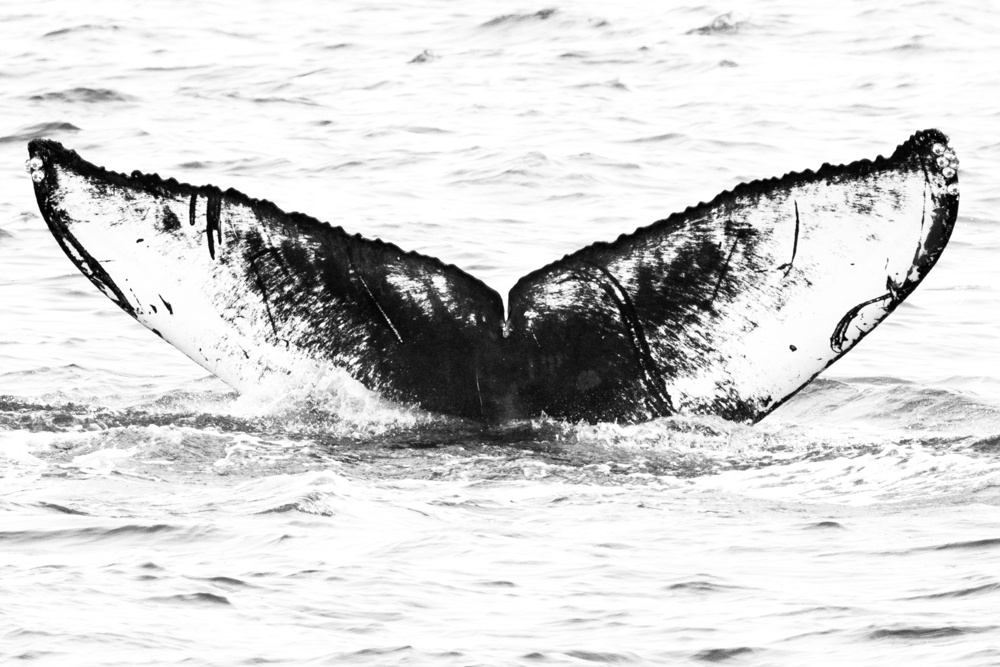

In [97]:
# crop images to tale only
# OR remove text and white space

# file = glob.glob(READ_PATH + '0a8b000b1.jpg')[0]
file = glob.glob(READ_PATH + '001c1ac5f.jpg')[0]
Image.open(file)

In [ ]:
# crop text band below images
# First calculate the "whiteness" of each row
# Then find the start of whiteness > THRESHOLD AND in the bottom half of the image
# crop image

In [16]:
THRESHOLD = 245
def remove_text(READ_PATH, WRITE_PATH, filename):
    #     print(i)
    file2 = glob.glob(READ_PATH + filename)[0]
    pic2 = Image.open(file2)
    pix2 = np.array(pic2)
    row_start_whiteness = math.floor(pix2.shape[0]/2)
    
    # determine from which row to remove text band
    if (len(pix2.shape) == 2):
        tmp = np.argmax(np.sum(pix2[row_start_whiteness:, :], axis = 1)/pix2.shape[1] > THRESHOLD) + row_start_whiteness
    elif (len(pix2.shape) == 3):
        tmp = np.argmax(np.sum(np.sum(pix2[row_start_whiteness:, :, :], axis = 2)/pix2.shape[2], axis = 1)/pix2.shape[1] > THRESHOLD) + row_start_whiteness
    
    # crop image
    if (tmp > row_start_whiteness):
        pic2.crop((0, 0, pix2.shape[1], tmp)).save(WRITE_PATH + filename[:-4] + '_crop.jpg')
    else:
        pic2.save(WRITE_PATH + filename)

In [18]:
for i in tqdm(os.listdir(READ_PATH)):
    remove_text(READ_PATH, WRITE_PATH, i)

100%|██████████████████████████████████████████████████████████████████████████| 25361/25361 [1:12:29<00:00,  4.28it/s]


**Image rescaling analysis**

In [5]:
# test image read
READ_PATH  = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_remove_text/'
WRITE_PATH = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_resized/'

files = glob.glob(READ_PATH + '*')
widths, heights = zip(*[Image.open(f).size for f in files])

count    25361.000000
mean       992.274043
std        267.167532
min         77.000000
25%       1000.000000
50%       1050.000000
75%       1050.000000
max       5959.000000
dtype: float64
954.0
1050.0


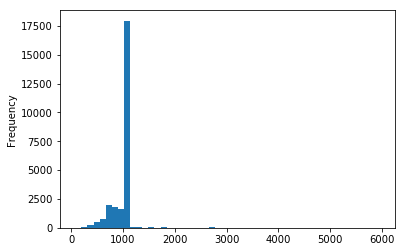

In [17]:
# about 2/3 of files have roughly the same length
x = pd.Series(widths)
x.plot(kind = "hist", bins = 50)
print(x.describe())
print(x.quantile(.23))
print(x.quantile(.98))

count    25361.000000
mean       504.650684
std        156.301490
min         30.000000
25%        392.000000
50%        523.000000
75%        605.000000
max       1575.000000
dtype: float64
405.0
751.0


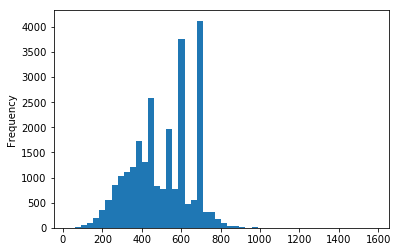

In [18]:
# cehcking heights, after removing text and white band, heights are spread out
x = pd.Series(heights)
x.plot(kind = "hist", bins = 50)
print(x.describe())
print(x.quantile(.30))
print(x.quantile(.98))

count    25361.000000
mean         2.138737
std          0.825628
min          0.500867
25%          1.526163
50%          1.782683
75%          2.334239
max         13.261364
dtype: float64
1.7326732673267327
4.498642533936646


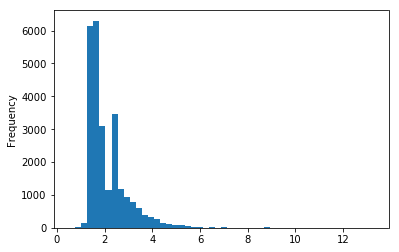

In [22]:
# aspect eatio
x = pd.Series(widths).divide(pd.Series(heights))
x.plot(kind = "hist", bins = 50)
print(x.describe())
print(x.quantile(.30))
print(x.quantile(.98))

In [25]:
# 80/20 solution... let's rescale to (1050,605) so few (25%) images lose granularity.
# We'll try adding original scale as suplemental variables later on

def resize(READ_PATH, WRITE_PATH, new_width, new_height):
    length = len(READ_PATH)
    files = glob.glob(READ_PATH+'*')
    for f in files:
        out = WRITE_PATH + f[length:]
        Image.open(f).resize(size=(new_width, new_height)).save(out)

resize(READ_PATH, WRITE_PATH, 1050, 605)

In [26]:
# color to black & white
def black_and_white(READ_PATH, WRITE_PATH, filename):
    #     print(i)
    file2 = glob.glob(READ_PATH + filename)[0]
    pic2 = Image.open(file2)
    pic2.convert('L').save(WRITE_PATH + filename)

In [27]:
READ_PATH  = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_resized/'
WRITE_PATH = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_black_and_white/'

for i in tqdm(os.listdir(READ_PATH)):
    black_and_white(READ_PATH, WRITE_PATH, i)

100%|████████████████████████████████████████████████████████████████████████████| 25361/25361 [46:09<00:00,  7.01it/s]


In [ ]:
# check dimension

In [28]:
READ_PATH  = 'C:/Users/KaiPin Liao/Documents/kaggle_whales/data/train_black_and_white/'

files = glob.glob(READ_PATH + '*')
widths, heights = zip(*[Image.open(f).size for f in files])

In [29]:
x = pd.Series(heights)
print(x.describe())

count    25361.0
mean       605.0
std          0.0
min        605.0
25%        605.0
50%        605.0
75%        605.0
max        605.0
dtype: float64


In [30]:
x = pd.Series(widths)
print(x.describe())

count    25361.0
mean      1050.0
std          0.0
min       1050.0
25%       1050.0
50%       1050.0
75%       1050.0
max       1050.0
dtype: float64
